# Load up required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from scipy.stats import multivariate_normal
import warnings #to ignore warnings
warnings.filterwarnings('ignore')
pd.set_option('future.no_silent_downcasting', True)

In [2]:
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
# Helper function to calculate misclassification
def calc_misclass(actual, predicted):
    return np.mean(actual != predicted)

# Helper function to calculate specificity
def calc_specificity(actual, predicted):
    tn, fp, _, _ = confusion_matrix(actual, predicted).ravel()
    specificity = tn / (tn+fp)
    return np.round(specificity,5)

# Helper function to calculate sensitivity
def calc_sensitivity(actual, predicted):
    _, _, fn, tp = confusion_matrix(actual, predicted).ravel()
    sensitivity = tp / (tp+fn)
    return np.round(sensitivity,5)

# Section 1

## Generating Synthetic Data

In [4]:
# setup parameters
num_obs = 1000

# means
mu_1 = np.array([12, 8.5])
mu_2 = np.array([22, 10])
mu_3 = np.array([12, 20])
mu_4 = np.array([12, 20])

# sigmas
sigma_1 = np.array([[10, -4], [-4, 8]])
sigma_2 = np.array([[5, -3], [-3, 5]])
sigma_3 = np.array([[8, 3], [3, 8]])
sigma_4 = np.array([[8, 6], [6, 8]])

# control randomization
np.random.seed(42)

# make estimation data
# create response
response_train = np.concatenate([
    np.repeat("A", num_obs // 2),
    np.repeat("B", num_obs),
    np.repeat("C", num_obs * 2),
    np.repeat("D", num_obs)
])

# create predictors
predictors_train = np.vstack([
    multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=num_obs // 2),
    multivariate_normal.rvs(mean=mu_2, cov=sigma_2, size=num_obs),
    multivariate_normal.rvs(mean=mu_3, cov=sigma_3, size=num_obs * 2),
    multivariate_normal.rvs(mean=mu_4, cov=sigma_4, size=num_obs)
])

# create dataframe for estimation data
train = pd.DataFrame(data=np.column_stack((response_train, predictors_train)), columns=["y", "x1", "x2"])

# make validation data
# create response
response_test = np.concatenate([
    np.repeat("A", num_obs // 2),
    np.repeat("B", num_obs),
    np.repeat("C", num_obs * 2),
    np.repeat("D", num_obs)
])

# create predictors
predictors_test = np.vstack([
    multivariate_normal.rvs(mean=mu_1, cov=sigma_1, size=num_obs // 2),
    multivariate_normal.rvs(mean=mu_2, cov=sigma_2, size=num_obs),
    multivariate_normal.rvs(mean=mu_3, cov=sigma_3, size=num_obs * 2),
    multivariate_normal.rvs(mean=mu_4, cov=sigma_4, size=num_obs)
])

# create dataframe for validation data
test = pd.DataFrame(data=np.column_stack((response_test, predictors_test)), columns=["y", "x1", "x2"])

#convert argument to a numeric type
train[['x1', 'x2']] = train[['x1', 'x2']].apply(pd.to_numeric, errors='coerce')
test[['x1', 'x2']] = test[['x1', 'x2']].apply(pd.to_numeric, errors='coerce')

# Show the dataframes
print(train.head())
print(test.head())

   y         x1         x2
0  A  10.393803   9.366696
1  A  12.220514  12.595005
2  A  12.350382   7.570433
3  A   8.533799  13.356502
4  A  14.077879   8.397769
   y         x1         x2
0  A  11.273346  12.074808
1  A   7.936105   6.230564
2  A  10.873111   6.141823
3  A  13.910390   9.754157
4  A  12.689012  11.178720


## Data Splitting And Standardization

In [5]:
seed = 666
train['y'] = train['y'].replace({'A':0, 'B':1, 'C':2, 'D':3})
test['y'] = test['y'].replace({'A':0, 'B':1, 'C':2, 'D':3})
est, val = train_test_split(train, test_size=0.5, random_state=seed)

X_train = train.drop(columns=['y'])
y_train = train['y'].astype('int')
X_test = test.drop(columns=['y'])
y_test = test['y'].astype('int')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_est = est.drop(columns=['y'])
y_est = est['y'].astype('int')
X_val = val.drop(columns=['y'])
y_val = val['y'].astype('int')

scaler = StandardScaler() #Different Scaler for estimation and validation sets
X_est_scaled = scaler.fit_transform(X_est)
X_val_scaled = scaler.transform(X_val)

## EDA

### Visualizing the distribution of observations

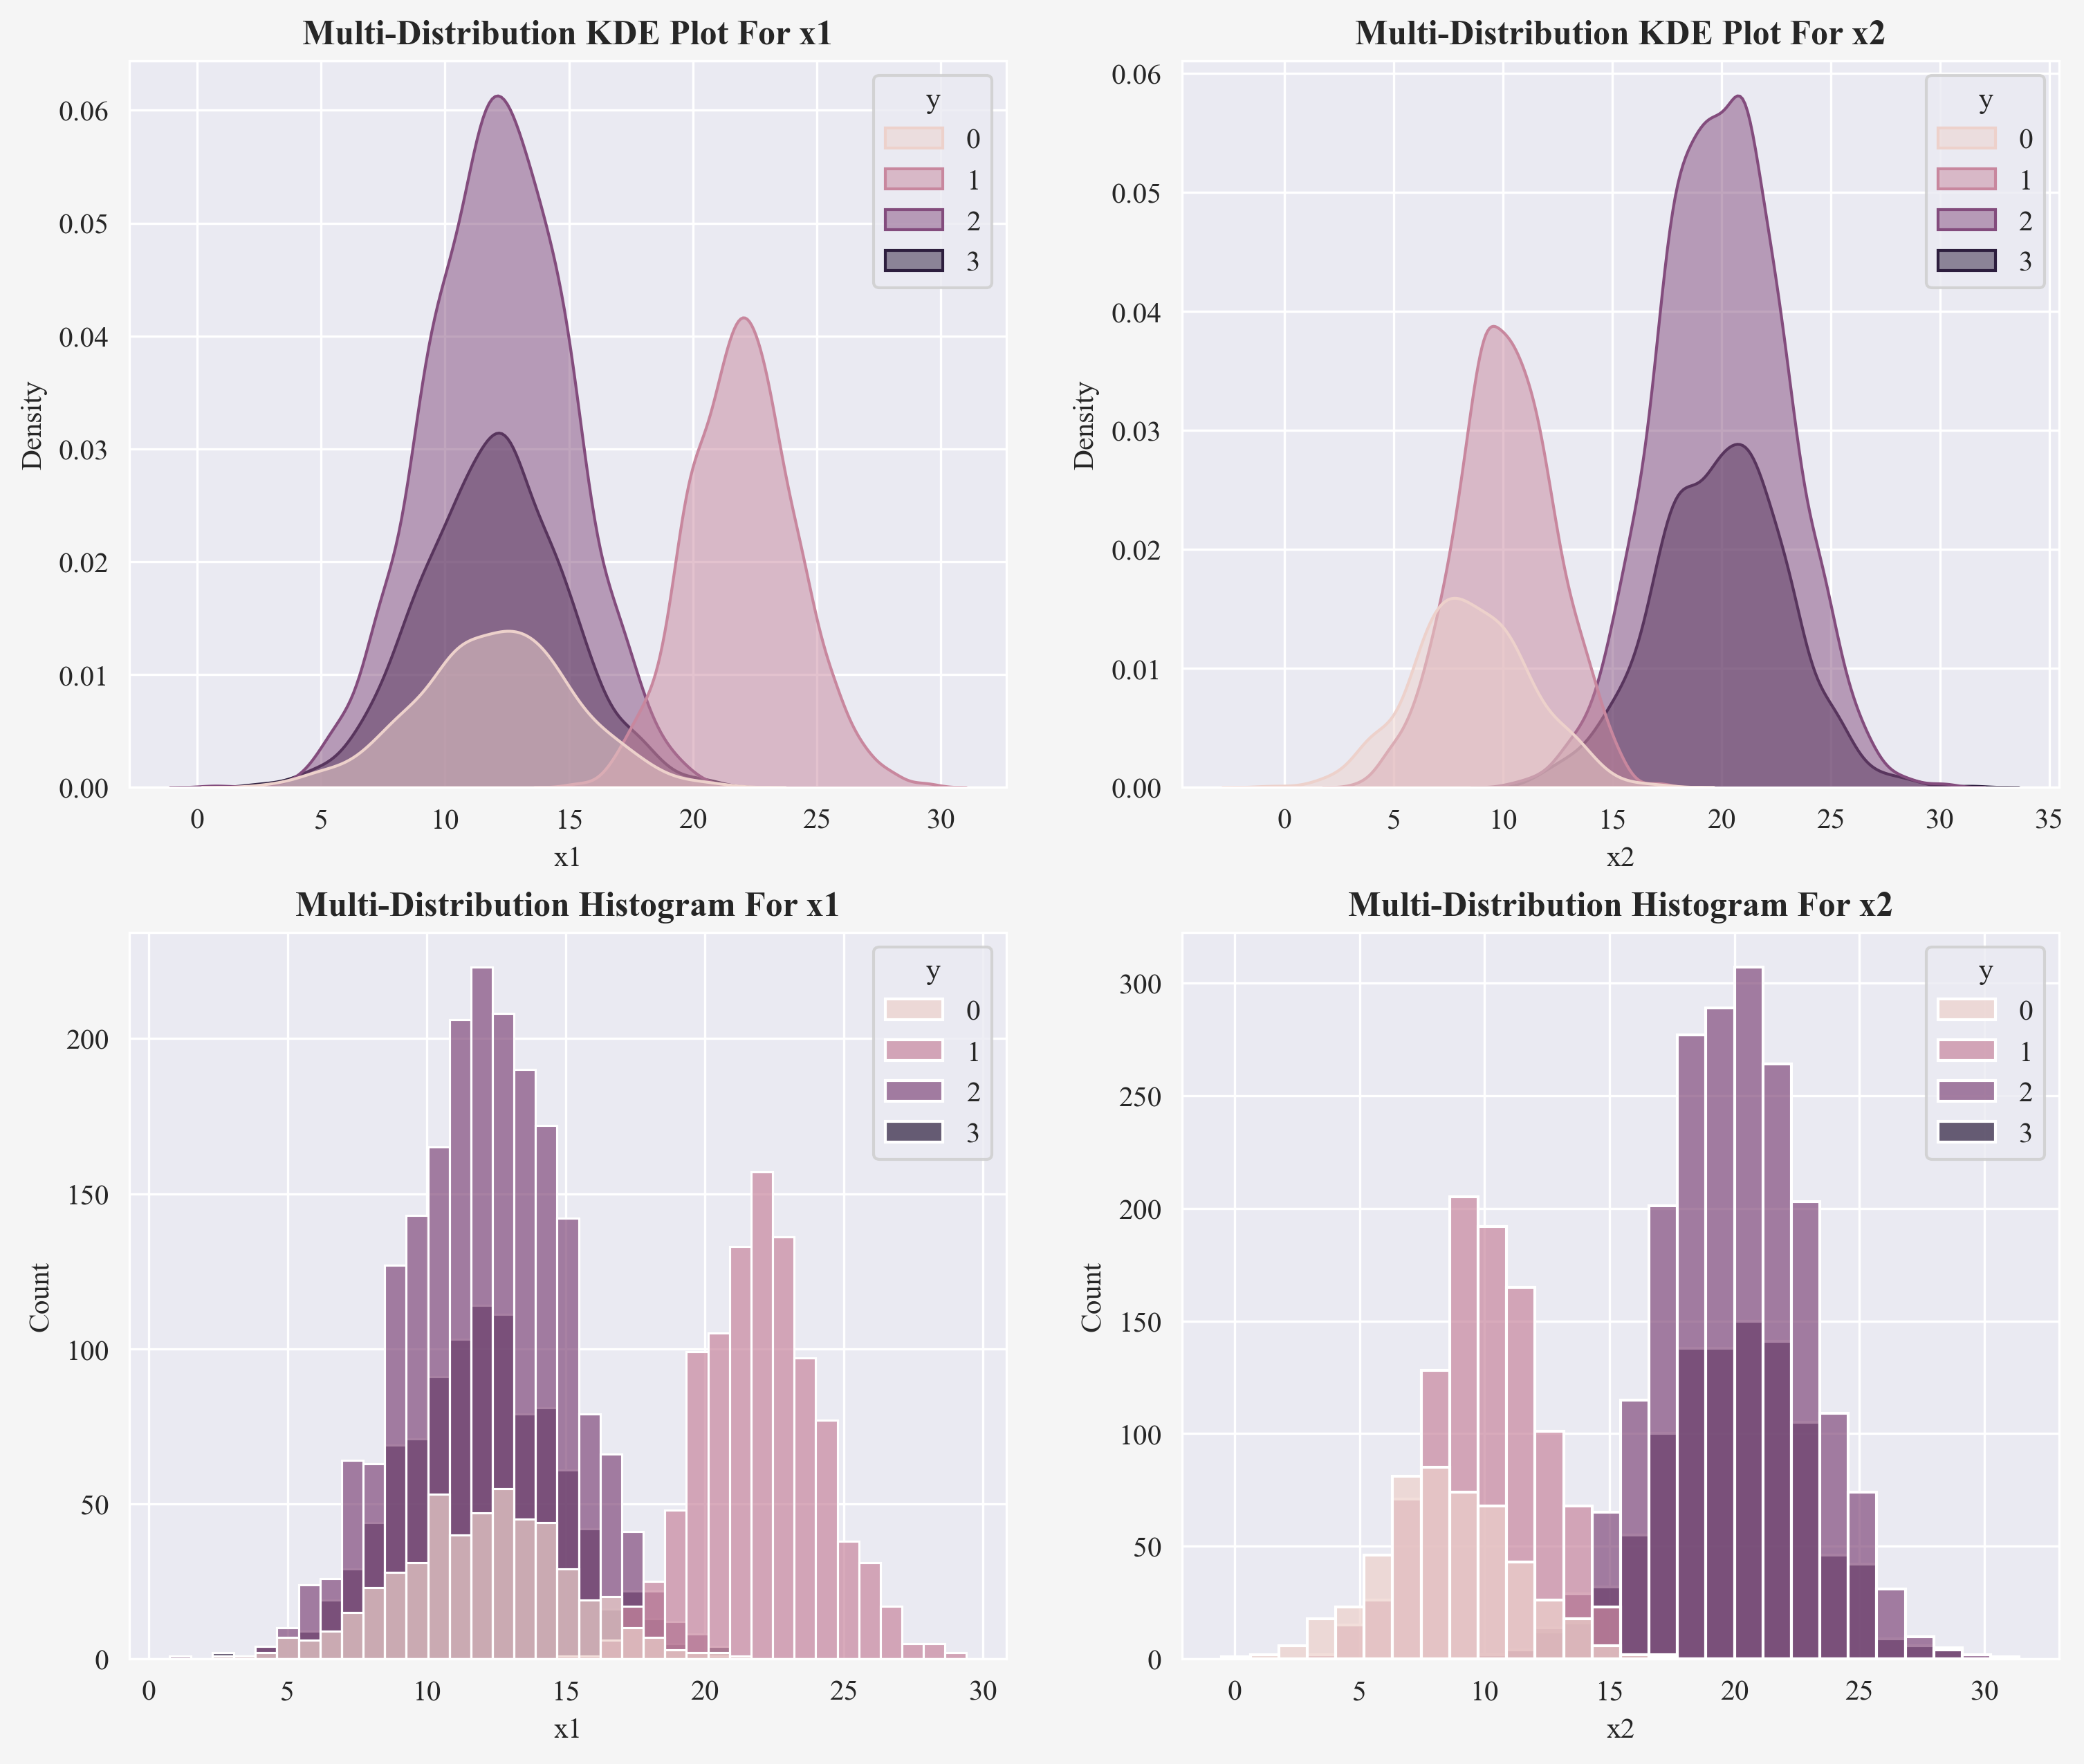

In [11]:
plt.figure(figsize=(12, 10), facecolor='whitesmoke', dpi=300)

#KDE plot for x1
plt.subplot(2, 2, 1)
sns.kdeplot(x='x1', data=train, fill=True, alpha=0.5, hue='y')
plt.title('Multi-Distribution KDE Plot For x1', weight='bold')

#KDE plot for x2
plt.subplot(2, 2, 2)
sns.kdeplot(x='x2', data=train, fill=True, alpha=0.5, hue='y')
plt.title('Multi-Distribution KDE Plot For x2', weight='bold')

#Histogram for x1
plt.subplot(2, 2, 3)
sns.histplot(x='x1', data=train, alpha=0.7, hue='y')
plt.title('Multi-Distribution Histogram For x1', weight='bold')

#Histogram for x2
plt.subplot(2, 2, 4)
sns.histplot(x='x2', data=train, alpha=0.7, hue='y')
plt.title('Multi-Distribution Histogram For x2', weight='bold');

### Visualizing interclass correlations

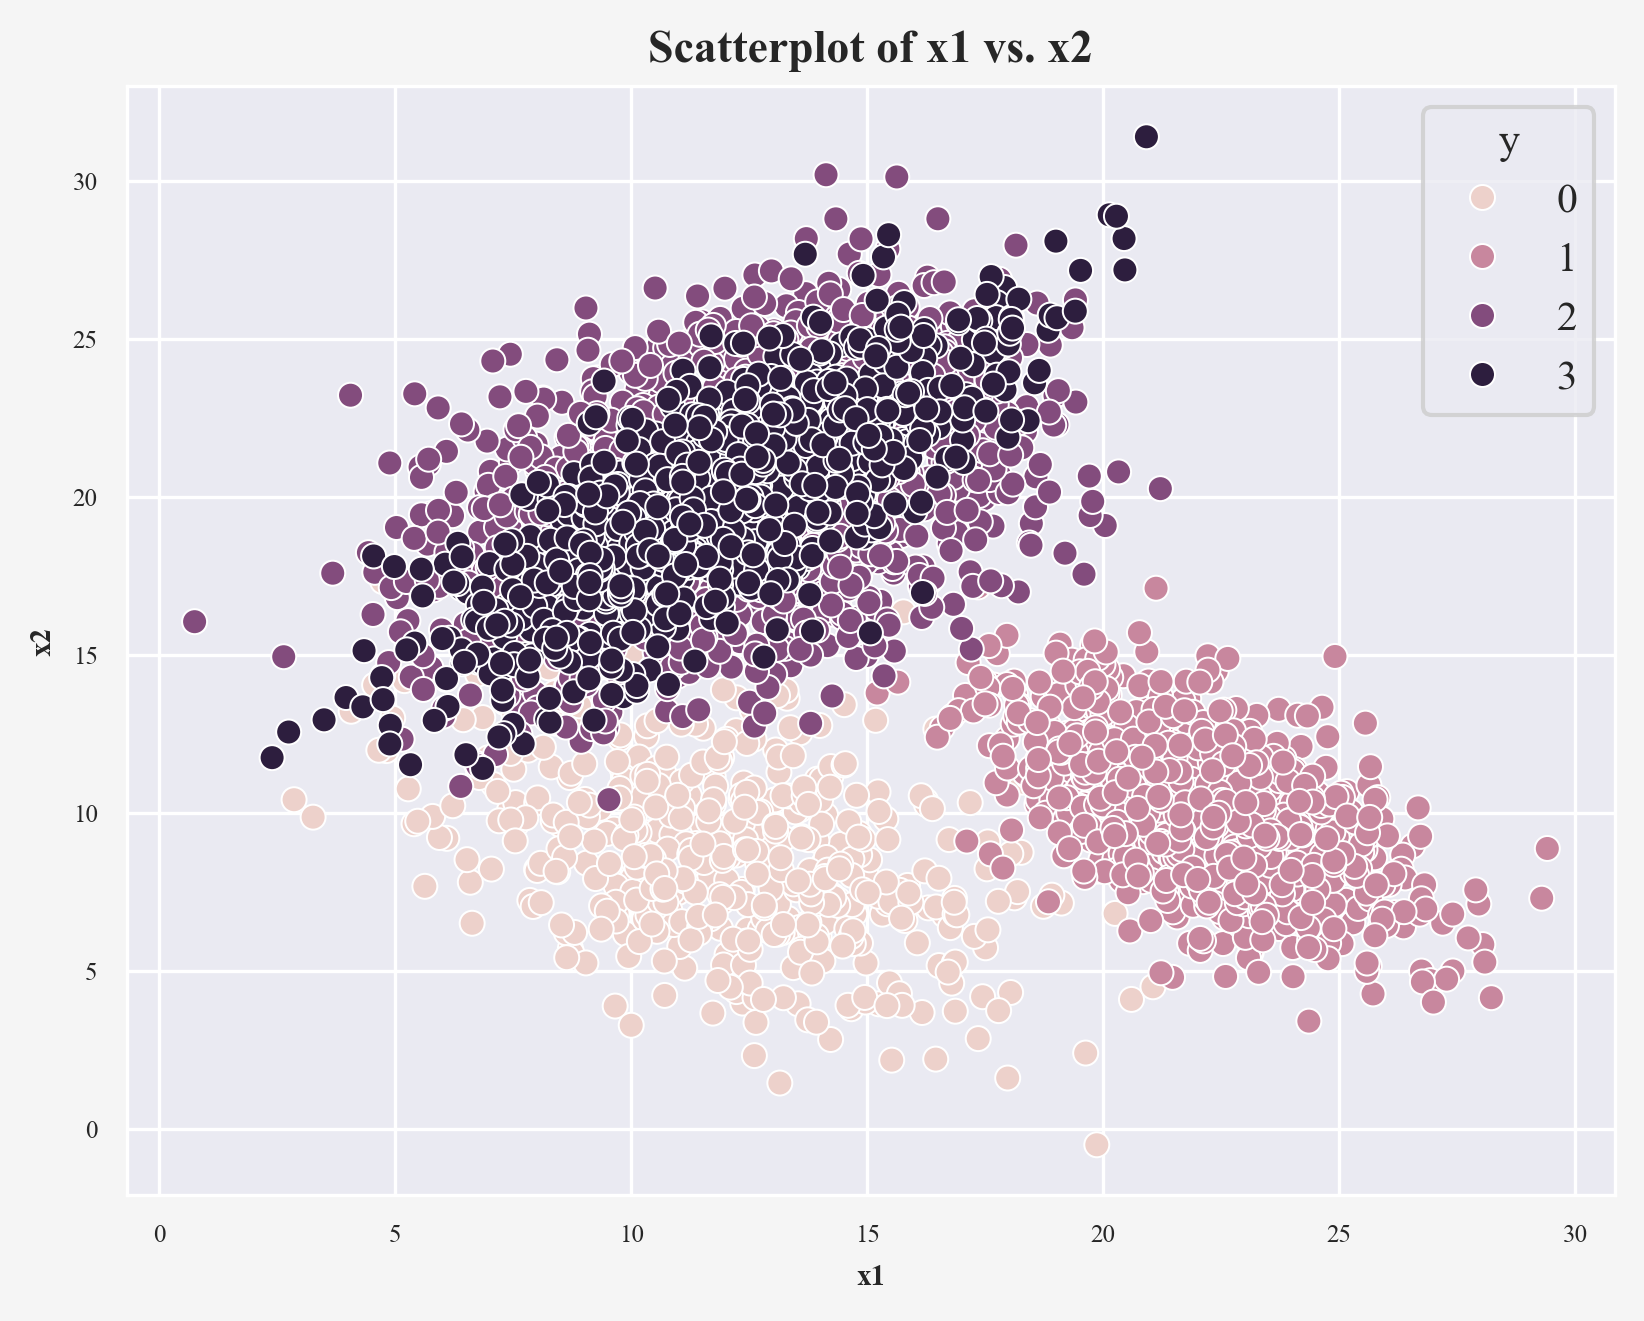

In [9]:
plt.figure(facecolor='whitesmoke', dpi=300)
plt.title('Scatterplot of x1 vs. x2', fontweight='bold', fontsize=11)
sns.scatterplot(data=train, x='x1', y='x2', hue='y')
plt.ylabel('x2', fontweight='bold', fontsize=7)
plt.xlabel('x1', fontweight='bold', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

## 1. Logistic Regression

### 1.1. Parameter tuning: C

In [12]:
misclass = []
Cs = np.linspace(0.01, 1, 100)

for c in Cs:
    rgr = LogisticRegression(random_state=seed, C=c)
    rgr.fit(X_est_scaled, y_est)
    
    y_val_pred = rgr.predict(X_val_scaled)
    rate = calc_misclass(y_val, y_val_pred)

    misclass.append(rate)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_c = np.round(Cs[min_idx],2)

print(f'best C is {best_c} with a misclassification rate of {misclass[min_idx]}')

best C is 0.06 with a misclassification rate of 0.23955555555555555


### 1.2. Fitting the best model on training set

In [14]:
rgr = LogisticRegression(random_state=seed, C=best_c)
rgr.fit(X_train_scaled, y_train)

y_test_pred = rgr.predict(X_test_scaled)
y_train_pred = rgr.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.76244
Train Error: 0.23756
Test Accuracy: 0.76533
Test Error: 0.23467

Confusion Matrix:
 [[ 459   12   29    0]
 [   2  994    4    0]
 [   8    1 1991    0]
 [   8    0  992    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       500
           1       0.99      0.99      0.99      1000
           2       0.66      1.00      0.79      2000
           3       0.00      0.00      0.00      1000

    accuracy                           0.77      4500
   macro avg       0.65      0.73      0.68      4500
weighted avg       0.62      0.77      0.68      4500



## 2. Polynomial Features with Logistic Regression

### 2.1. Parameter tuning: C

First, we tune the `C` parameter on a wide range of values. Later, we will refine the result with a smaller grid.

In [15]:
misclass = []
Cs = np.linspace(1, 100, 100)
ply = PolynomialFeatures(degree=2)

X_est_poly = ply.fit_transform(X_est_scaled)
X_val_poly = ply.transform(X_val_scaled)

for c in Cs:
    rgr = LogisticRegression(C=c, random_state=seed)
    rgr.fit(X_est_poly, y_est)
    
    y_val_pred = rgr.predict(X_val_poly)
    rate = calc_misclass(y_val, y_val_pred)

    misclass.append(rate)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_c = np.round(Cs[min_idx],2)

print(f'best C is {best_c} with a misclassification rate of {misclass[min_idx]}')

best C is 6.0 with a misclassification rate of 0.23466666666666666


### 2.2 Refine with a smaller grid of values based on best values from the big grid above

In [16]:
misclass = []
Cs = np.linspace(best_c - 1, best_c + 1, 2*100)

for c in Cs:
    rgr = LogisticRegression(C=c, random_state=seed)
    rgr.fit(X_est_poly, y_est)
    
    y_val_pred = rgr.predict(X_val_poly)
    rate = calc_misclass(y_val, y_val_pred)

    misclass.append(rate)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_c = np.round(Cs[min_idx],2)

print(f'best C is {best_c} with a misclassification rate of {misclass[min_idx]}')

best C is 5.23 with a misclassification rate of 0.23466666666666666


### 2.3. Fitting the best model with the training set

In [17]:
ply = PolynomialFeatures(degree=2)
rgr = LogisticRegression(C=best_c, random_state=seed)

X_train_poly = ply.fit_transform(X_train_scaled)
X_test_poly = ply.transform(X_test_scaled)
rgr.fit(X_train_poly, y_train)

y_test_pred = rgr.predict(X_test_poly)
y_train_pred = rgr.predict(X_train_poly)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.77111
Train Error: 0.22889
Test Accuracy: 0.76044
Test Error: 0.23956

Confusion Matrix:
 [[ 469    2   22    7]
 [  13  984    3    0]
 [   6    1 1920   73]
 [   7    0  944   49]]


## 3. Linear Discriminant Analysis (LDA)

In [18]:
cls = LinearDiscriminantAnalysis()

cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.75511
Train Error: 0.24489
Test Accuracy: 0.75556
Test Error: 0.24444

Confusion Matrix:
 [[ 421   48   31    0]
 [   4  987    9    0]
 [   7    1 1992    0]
 [   5    0  995    0]]


## 4. Polynomial Linear Discriminant Analysis

In [19]:
ply = PolynomialFeatures(degree=2)
cls = LinearDiscriminantAnalysis()

X_train_poly = ply.fit_transform(X_train_scaled)
X_test_poly = ply.transform(X_test_scaled)

cls.fit(X_train_poly, y_train)

y_test_pred = cls.predict(X_test_poly)
y_train_pred = cls.predict(X_train_poly)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.76067
Train Error: 0.23933
Test Accuracy: 0.76044
Test Error: 0.23956

Confusion Matrix:
 [[ 456    6   34    4]
 [   7  978   15    0]
 [   2    0 1976   22]
 [   6    0  982   12]]


## 5. Flat Linear Discriminant Analysis

In [26]:
priors = np.full((1,len(y_train.unique())), 1 / len(y_train.unique()))

cls = LinearDiscriminantAnalysis(priors=priors)

cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.65556
Train Error: 0.34444
Test Accuracy: 0.64444
Test Error: 0.35556

Confusion Matrix:
 [[ 442   37    1   20]
 [  14  981    5    0]
 [  25    0  959 1016]
 [   8    0  474  518]]


## 6. Quadratic Discriminant Analysis (QDA)

In [27]:
cls = QuadraticDiscriminantAnalysis()

cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.76844
Train Error: 0.23156
Test Accuracy: 0.76222
Test Error: 0.23778

Confusion Matrix:
 [[ 470    3   18    9]
 [  10  987    3    0]
 [   8    1 1907   84]
 [   7    0  927   66]]


## 7. Flat QDA

In [29]:
cls = QuadraticDiscriminantAnalysis(priors=priors)

cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.68867
Train Error: 0.31133
Test Accuracy: 0.69378
Test Error: 0.30622

Confusion Matrix:
 [[ 486    1    4    9]
 [  13  985    2    0]
 [  29    2  873 1096]
 [  14    0  208  778]]


## 8. Gaussian Naïve Bayes

In [30]:
cls = GaussianNB()

cls.fit(X_train_scaled, y_train)
y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.76044
Train Error: 0.23956
Test Accuracy: 0.762
Test Error: 0.238

Confusion Matrix:
 [[ 461   15   24    0]
 [   6  981   13    0]
 [  13    0 1987    0]
 [   9    0  991    0]]


## 9. K-Nearest Neighbors

### 9.1. Getting the optimal value of K

In [31]:
misclass = []
n_neighbors = np.linspace(1,50,50).astype('int')

for k in n_neighbors:
    cls = KNeighborsClassifier(n_neighbors=k)
    cls.fit(X_est_scaled, y_est)

    y_val_pred = cls.predict(X_val_scaled)
    error = calc_misclass(y_val, y_val_pred)

    misclass.append(error)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_k = n_neighbors[min_idx]

print(f'best K is {best_k} with a misclassification rate of {misclass[min_idx]}')

best K is 49 with a misclassification rate of 0.24133333333333334


In [34]:
pd.DataFrame({'n_neighbors':n_neighbors,
              'validation misclass':misclass}).set_index('n_neighbors').tail()

validation misclass
n_neighbors                     
46                      0.242667
47                      0.245333
48                      0.243556
49                      0.241333
50                      0.244000

### 9.2. Fitting the best model with the training set

In [35]:
cls = KNeighborsClassifier(n_neighbors=best_k)
cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.76511
Train Error: 0.23489
Test Accuracy: 0.75756
Test Error: 0.24244

Confusion Matrix:
 [[ 463    9   21    7]
 [   4  993    3    0]
 [   7    1 1877  115]
 [   7    0  917   76]]


## 10. Classification Decision Tree

### 10.1. Parameter tuning: max_depth

In [36]:
misclass = []
depths = np.linspace(1,100,100).astype('int')

for depth in depths:
    cls = DecisionTreeClassifier(max_depth=depth,
                                 random_state=seed)
    cls.fit(X_est_scaled, y_est)

    y_val_pred = cls.predict(X_val_scaled)
    error = calc_misclass(y_val, y_val_pred)

    misclass.append(error)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_depth = n_neighbors[min_idx]

print(f'best max_depth is {best_depth} with a misclassification rate of {misclass[min_idx]}')

best max_depth is 5 with a misclassification rate of 0.24444444444444444


In [37]:
pd.DataFrame({'max_depth':depths,
              'validation misclass':misclass}).set_index('max_depth').head(6)

validation misclass
max_depth                     
1                     0.356000
2                     0.255111
3                     0.252444
4                     0.246222
5                     0.244444
6                     0.252000

### 10.2. Parameter tuning: min_samples_split

According to the paper, An empirical study on hyperparameter tuning of decision trees, the ideal min_samples_split values tend to be between 1 to 40 for the CART algorithm which is the algorithm implemented in scikit-learn.

In [38]:
misclass = []
sample_splits = np.linspace(2,40,39).astype('int')

for sample_split in sample_splits:
    cls = DecisionTreeClassifier(max_depth=best_depth,
                                 min_samples_split=sample_split,
                                 random_state=seed)
    cls.fit(X_est_scaled, y_est)

    y_val_pred = cls.predict(X_val_scaled)
    error = calc_misclass(y_val, y_val_pred)

    misclass.append(error)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_sample_split = sample_splits[min_idx]

print(f'best min_samples_split is {best_sample_split} with a misclassification rate of {misclass[min_idx]}')

best min_samples_split is 8 with a misclassification rate of 0.24222222222222223


In [39]:
pd.DataFrame({'min_samples_split':sample_splits,
              'validation misclass':misclass}).set_index('min_samples_split').iloc[3:8]

validation misclass
min_samples_split                     
5                             0.245333
6                             0.244889
7                             0.244889
8                             0.242222
9                             0.242222

### 10.3. Parameter tuning: min_samples_leaf

In [40]:
misclass = []
sample_leaves = np.linspace(1,20,20).astype('int')

for sample_leaf in sample_leaves:
    cls = DecisionTreeClassifier(max_depth=best_depth,
                                 min_samples_split=best_sample_split,
                                 min_samples_leaf=sample_leaf,
                                 random_state=seed)
    cls.fit(X_est_scaled, y_est)

    y_val_pred = cls.predict(X_val_scaled)
    error = calc_misclass(y_val, y_val_pred)

    misclass.append(error)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_sample_leaf = sample_leaves[min_idx]

print(f'best min_samples_leaf is {best_sample_leaf} with a misclassification rate of {misclass[min_idx]}')

best min_samples_leaf is 6 with a misclassification rate of 0.24177777777777779


In [41]:
pd.DataFrame({'min_samples_leaf':sample_leaves,
              'validation misclass':misclass}).set_index('min_samples_leaf').iloc[3:8]

validation misclass
min_samples_leaf                     
4                            0.242222
5                            0.242222
6                            0.241778
7                            0.242222
8                            0.244444

### 10.4. Fitting the best model with the training set

In [42]:
cls = DecisionTreeClassifier(max_depth=best_depth,
                             min_samples_split=best_sample_split,
                             min_samples_leaf=best_sample_leaf,
                             random_state=seed)
cls.fit(X_train_scaled, y_train)

y_test_pred = cls.predict(X_test_scaled)
y_train_pred = cls.predict(X_train_scaled)

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.77044
Train Error: 0.22956
Test Accuracy: 0.75756
Test Error: 0.24244

Confusion Matrix:
 [[ 459    7   31    3]
 [  22  968    9    1]
 [  12    2 1956   30]
 [   2    0  972   26]]


## Section 1 Final Results

| Model | Train Accuracy | Train Misclass Rate | Test Accuracy | Test Misclass Rate |
| --- | --- | --- | --- | --- |
| Logistic Regression | 0.76244 | 0.23756 | 0.76533 | 0.23467 |
| Logistic Regression (Polynomial) | 0.77111 | 0.22889 | 0.76044 | 0.23956 |
| LDA | 0.75511 | 0.24489 | 0.75556 | 0.24444 |
| LDA (Polynomial) | 0.76067 | 0.23933 | 0.76044 | 0.23956 |
| LDA (Flat Prior) | 0.65556 | 0.34444 | 0.64444 | 0.35556 |
| QDA | 0.76844 | 0.23156 | 0.76222 | 0.23778 |
| QDA (Flat Prior) | 0.68867 | 0.31133 | 0.69378 | 0.30622 |
| Gaussian NB | 0.76044 | 0.23956 | 0.762 | 0.238 |
| Classification KNN | 0.76511 | 0.23489 | 0.75756 | 0.24244 |
| Classification Decision Tree | 0.77044 | 0.22956 |0.75756 | 0.24244 |

As can be seen, Logistic Regression has the lowest misclassification rate.

&nbsp;

# Section 2

Throughout this section, we will be using the Breast Cancer Wisconsin (Diagnostic) dataset.

In [46]:
#reading the data into a pandas dataframe
wisc_train = pd.read_csv('data/wisc-est.csv')
wisc_test = pd.read_csv('data/wisc-val.csv')
wisc_train.head()

class  radius  texture  perimeter    area  smoothness  compactness  \
0     M  19.210    18.57     125.50  1152.0     0.10530      0.12670   
1     B  13.150    15.34      85.31   538.9     0.09384      0.08498   
2     B  14.860    16.94      94.89   673.7     0.08924      0.07074   
3     M  19.000    18.91     123.40  1138.0     0.08217      0.08028   
4     B   8.726    15.83      55.84   230.9     0.11500      0.08201   

   concavity  concave  symmetry  fractal  
0    0.13230  0.08994    0.1917  0.05961  
1    0.09293  0.03483    0.1822  0.06207  
2    0.03346  0.02877    0.1573  0.05703  
3    0.09271  0.05627    0.1946  0.05044  
4    0.04132  0.01924    0.1649  0.07633

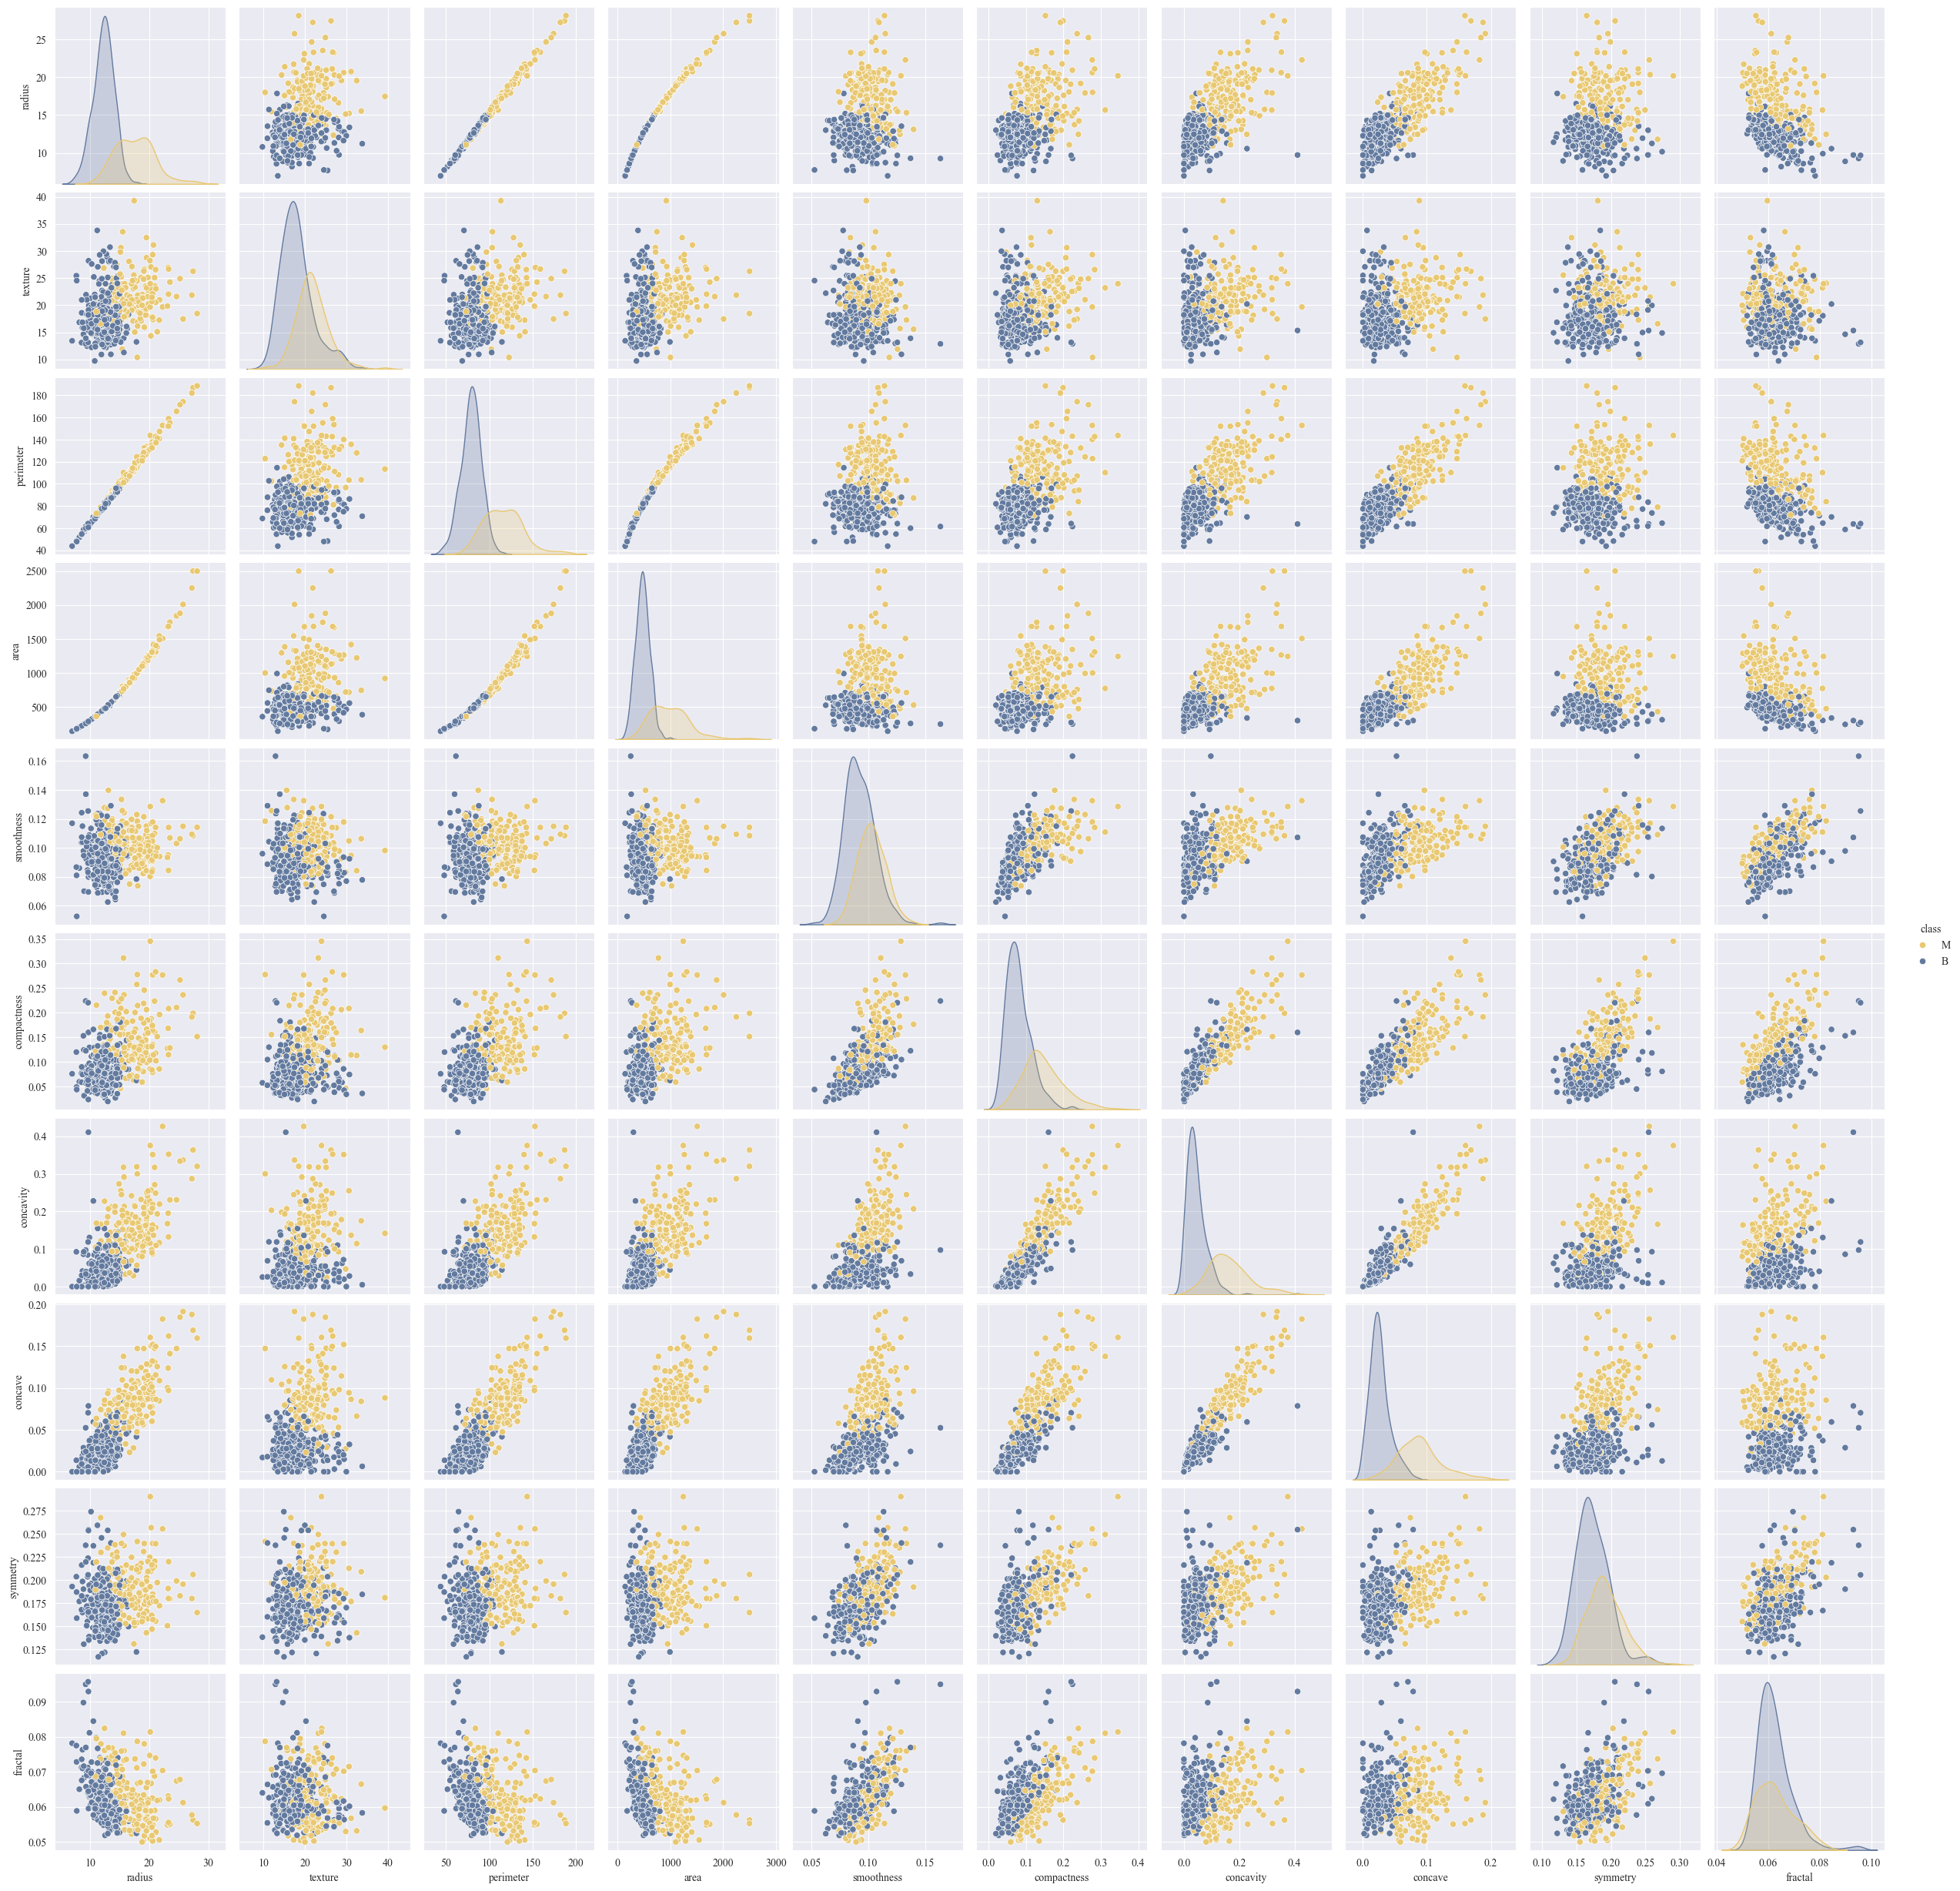

In [48]:
sns.pairplot(wisc_train, hue='class', palette=['#E8C872','#637A9F']);

In [49]:
#Data Splitting And Standardization
seed = 666
wisc_train['class'] = wisc_train['class'].replace({'M':1, 'B':0})
wisc_test['class'] = wisc_test['class'].replace({'M':1, 'B':0})
wisc_est, wisc_val = train_test_split(wisc_train, test_size=0.2, random_state=seed)

X_train = wisc_train.drop(columns=['class'])
y_train = wisc_train['class'].astype('int')
X_test = wisc_test.drop(columns=['class'])
y_test = wisc_test['class'].astype('int')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_est = wisc_est.drop(columns=['class'])
y_est = wisc_est['class'].astype('int')
X_val = wisc_val.drop(columns=['class'])
y_val = wisc_val['class'].astype('int')

scaler = StandardScaler() #Different Scaler for estimation and validation sets
X_est_scaled = scaler.fit_transform(X_est)
X_val_scaled = scaler.transform(X_val)

## Implementing Logistic Regression

### 1. Getting the optimal value of C

In [50]:
misclass = []
Cs = np.linspace(0.01, 1, 100)

for c in Cs:
    rgr = LogisticRegression(C=c, random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    
    y_val_pred = rgr.predict(X_val_scaled)
    rate = calc_misclass(y_val, y_val_pred)

    misclass.append(rate)

min_idx = np.where(misclass==np.min(misclass))[0][0]
best_c = np.round(Cs[min_idx],2)

print(f'best C is {best_c} with a misclassification rate of {misclass[min_idx]}')

best C is 0.49 with a misclassification rate of 0.031914893617021274


### 2. Variation with Cut-Off

In [51]:
specificities = []
sensitivities = []
accuracies = []
thresholds = np.linspace(0,1,101)

rgr = LogisticRegression(C=best_c, random_state=seed)
rgr.fit(X_est_scaled, y_est)

for x in thresholds:
    y_val_probs = (rgr.predict_proba(X_val_scaled) > x).astype('int')
    y_val_pred = y_val_probs[:,1]
    
    specificity = calc_specificity(y_val,y_val_pred)
    sensitivity = calc_sensitivity(y_val,y_val_pred)
    accuracy = np.round(accuracy_score(y_val,y_val_pred),5)

    specificities.append(specificity)
    sensitivities.append(sensitivity)
    accuracies.append(accuracy)

In [52]:
cutoff_results = pd.DataFrame({'Cut-Off Value':thresholds,
                           'Specificity':specificities,
                           'Sensitivity':sensitivities,
                           'Accuracy':accuracies}).set_index('Cut-Off Value')
cutoff_results

Specificity  Sensitivity  Accuracy
Cut-Off Value                                    
0.00               0.00000      1.00000   0.31915
0.01               0.35938      1.00000   0.56383
0.02               0.51562      1.00000   0.67021
0.03               0.65625      1.00000   0.76596
0.04               0.67188      1.00000   0.77660
...                    ...          ...       ...
0.96               1.00000      0.76667   0.92553
0.97               1.00000      0.73333   0.91489
0.98               1.00000      0.70000   0.90426
0.99               1.00000      0.63333   0.88298
1.00               1.00000      0.00000   0.68085

[101 rows x 3 columns]

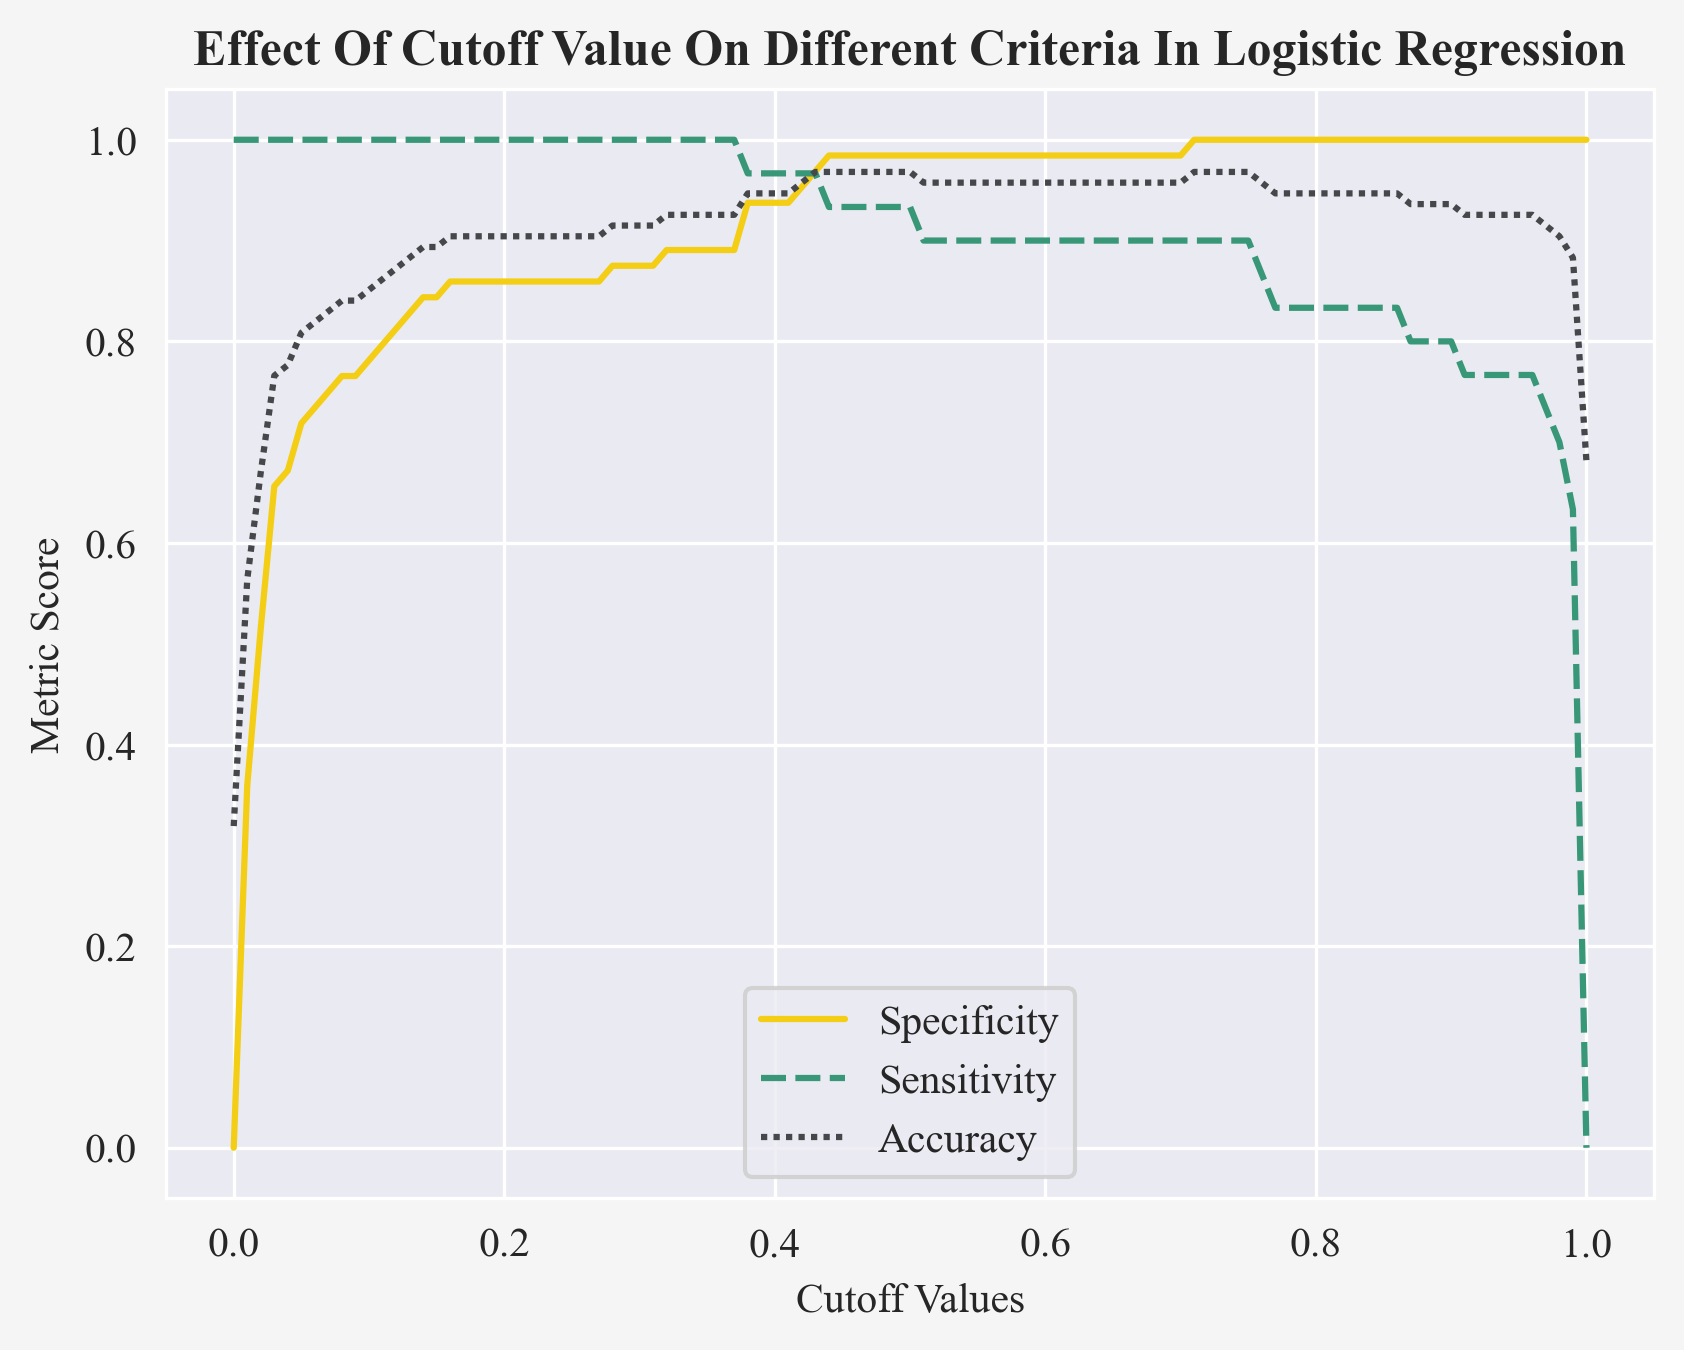

In [53]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(cutoff_results, palette=['#F4CE14','#379777','#45474B'])
plt.title('Effect of cutoff value on different criteria in logistic regression'.title(), weight='bold')
plt.xlabel('Cutoff Values')
plt.ylabel('Metric Score');

### 3. Choosing the optimal cut-off value

The plot between sensitivity, specificity, and accuracy shows their variation with various values of cut-off. Also can be seen from the plot the sensitivity and specificity are inversely proportional. The point where the sensitivity and specificity curves cross each other gives the optimum cut-off value.

In [54]:
values = cutoff_results.values
values.sort(axis=1)

values_diff = np.diff(values)
sum_diffs = np.sum(values_diff, axis=1)
optimal_idx = np.where(sum_diffs==np.min(sum_diffs))[0][0]

print(cutoff_results.iloc[optimal_idx])
best_cutoff = cutoff_results.iloc[optimal_idx].name

Specificity    0.96875
Sensitivity    0.96667
Accuracy       0.96809
Name: 0.43, dtype: float64


The point where the distance between Specificity, Sensitivity and Accuracy is minimum is equal to 0.43, which has an accuracy score of 0.96809, sensitivity score of 0.96667 and a specificity score of 0.96875.

### 4. Fitting the best model with the training set

In [55]:
rgr = LogisticRegression(C=best_c, random_state=seed)
rgr.fit(X_train_scaled, y_train)

y_test_probs = (rgr.predict_proba(X_test_scaled) > best_cutoff).astype('int')
y_test_pred = y_test_probs[:,1]

y_train_probs = (rgr.predict_proba(X_train_scaled) > best_cutoff).astype('int')
y_train_pred = y_train_probs[:,1]

print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
print("Train Error:", np.round(calc_misclass(y_train, y_train_pred),5))
print("Test Accuracy:", np.round(accuracy_score(y_test, y_test_pred),5))
print("Test Error:", np.round(calc_misclass(y_test, y_test_pred),5))

Train Accuracy: 0.95522
Train Error: 0.04478
Test Accuracy: 0.91
Test Error: 0.09


### 5. ROC Curve and AUC

AUC ROC stands for “Area Under the Curve” of the “Receiver Operating Characteristic” curve. The AUC ROC curve is basically a way of measuring the performance of an ML model. AUC measures the ability of a binary classifier to distinguish between classes and is used as a summary of the ROC curve.

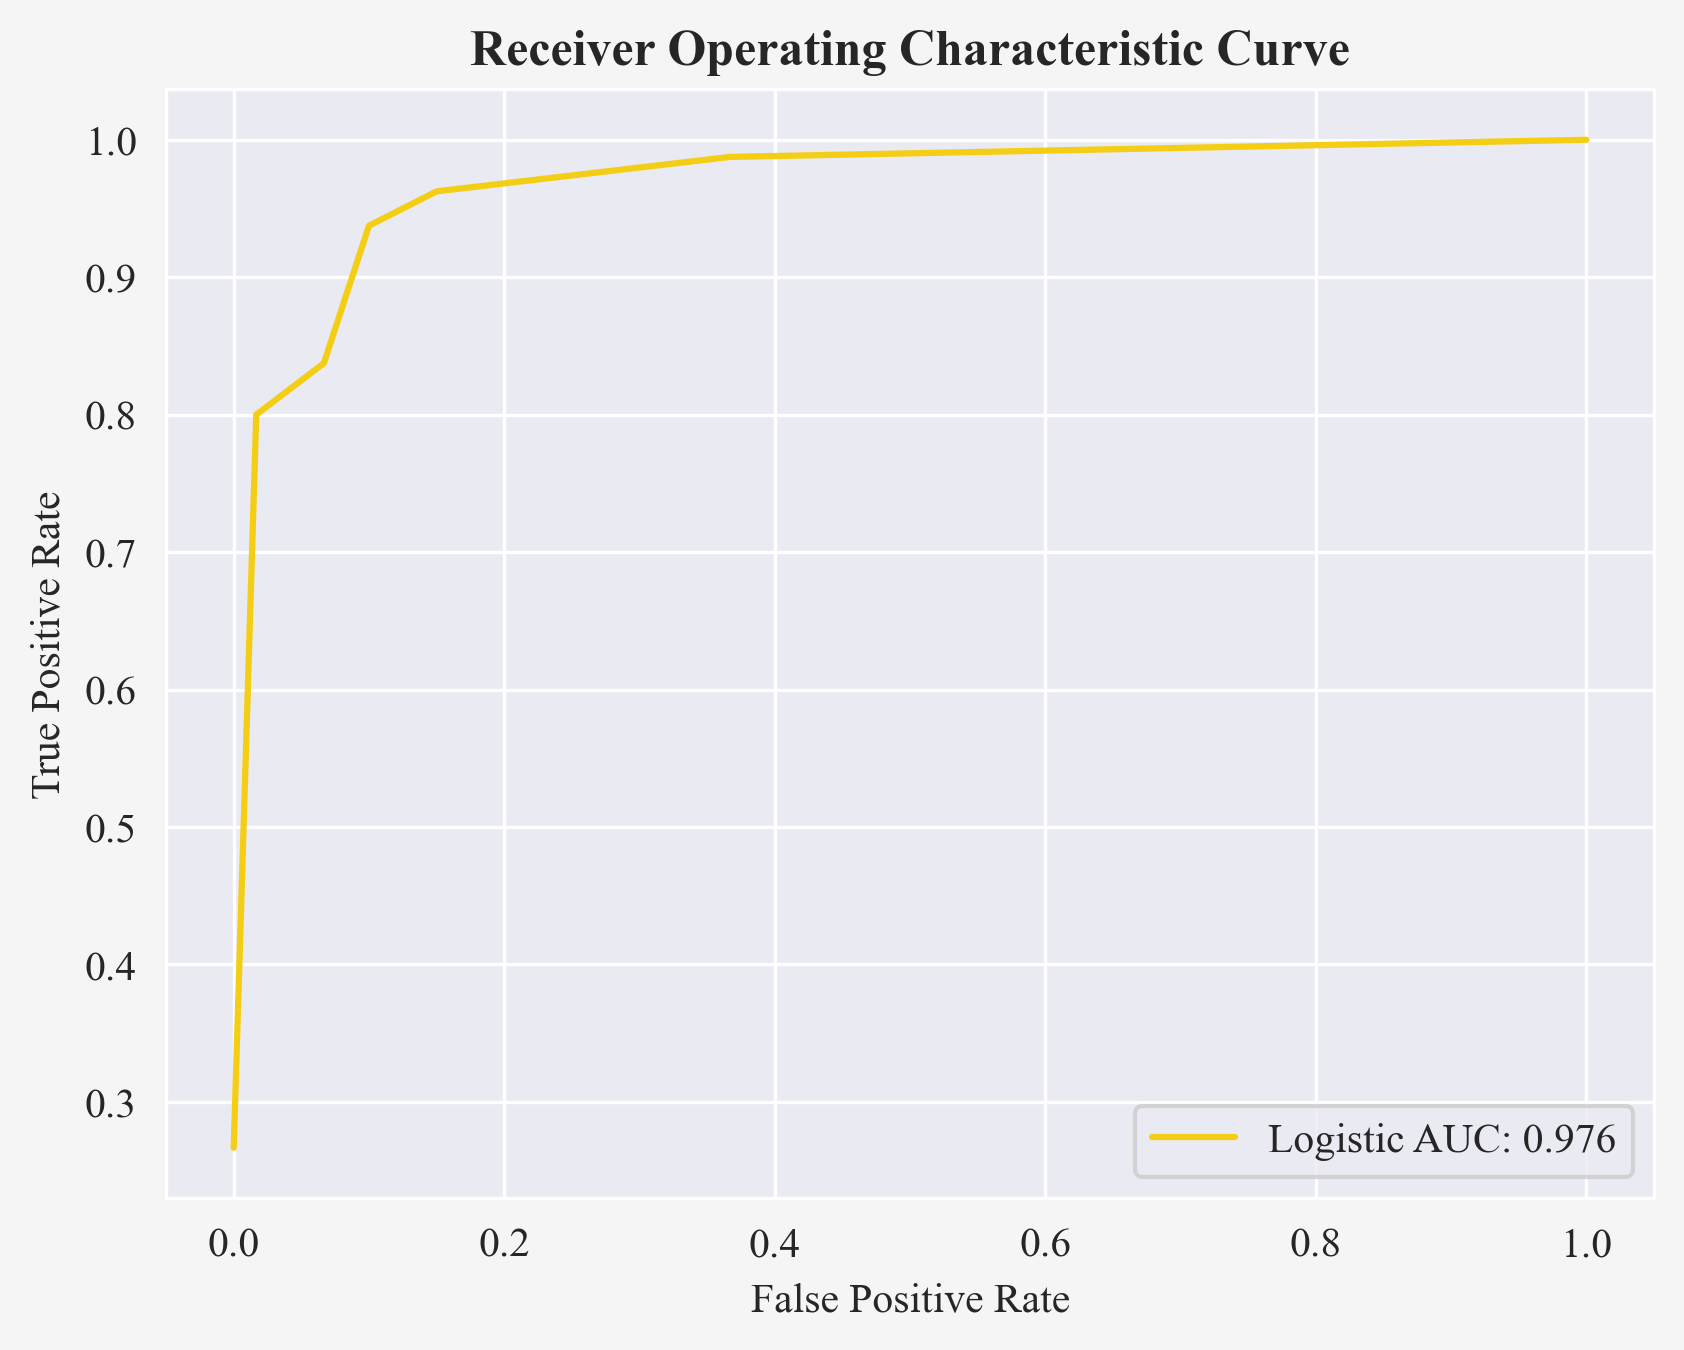

In [57]:
y_test_pred_function = rgr.decision_function(X_test_scaled)

fpr, tpr, threshold = roc_curve(y_test, y_test_pred_function)
auc_logistic = np.round(auc(fpr, tpr),3)

plt.figure(facecolor='whitesmoke', dpi=300)
ax = sns.lineplot(x=fpr, y=tpr, color='#F4CE14', label=f'Logistic AUC: {auc_logistic}', ci=None)
#ax.text(0.5, 0.5, f'Logistic AUC: {auc_logistic}')
plt.title('Receiver operating characteristic curve'.title(), weight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### 6. Logistic Regression Decision Boundary

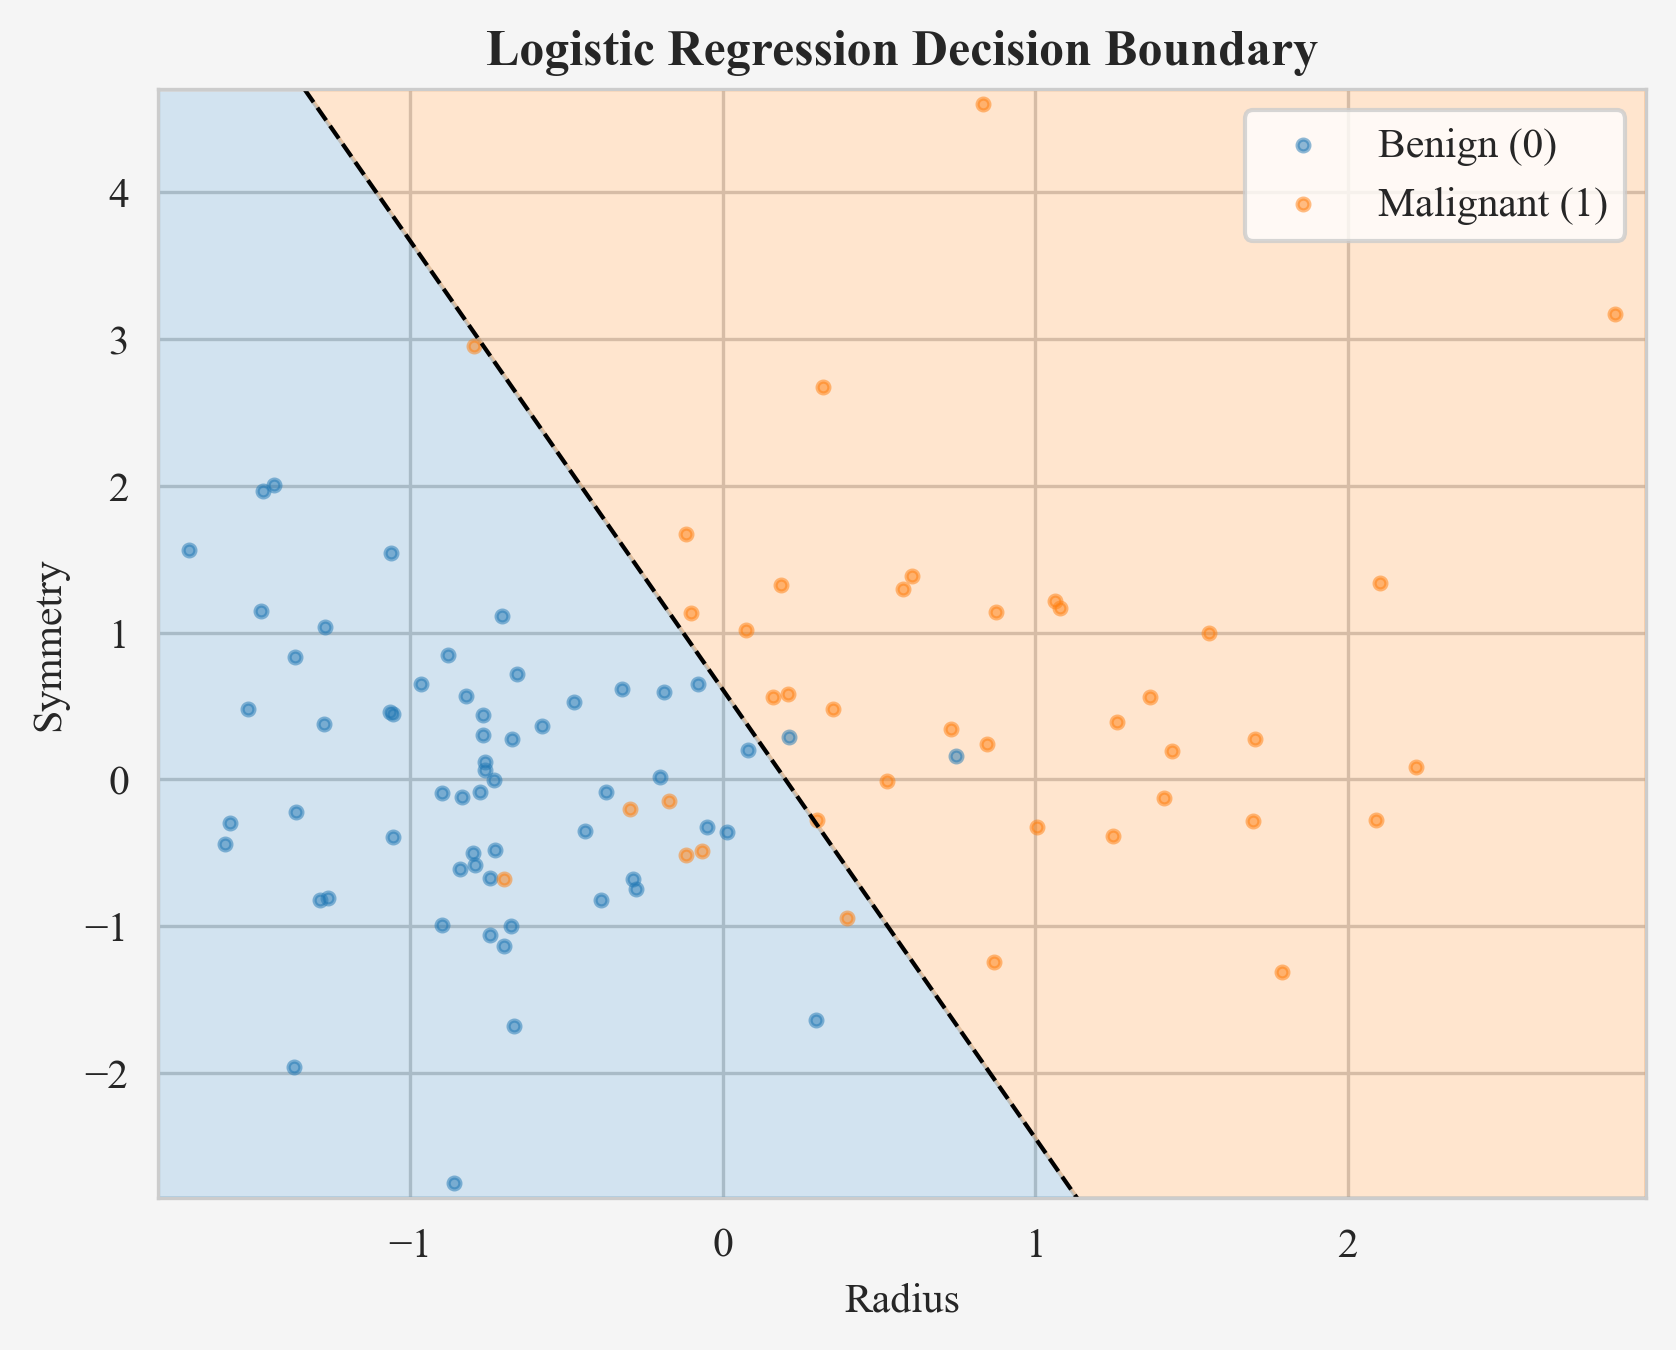

In [64]:
clf = LogisticRegression(random_state=seed)
clf.fit(X_train_scaled[:,[0,-2]], y_train) #only radius and symmetry

X = X_test_scaled[:,[0,-2]].copy()
y_test_pred = clf.predict(X)

# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T

# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = np.min(X[:,0])-.1, np.max(X[:,0])+.1
ymin, ymax = np.min(X[:,1])-.1, np.max(X[:,1])+.1
xd = np.array([xmin, xmax])
yd = m*xd + c

plt.figure(facecolor='whitesmoke', dpi=300)
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X_test_scaled[:,[0,-2]][y_test==0].T, s=8, alpha=0.5, label='Benign (0)')
plt.scatter(*X_test_scaled[:,[0,-2]][y_test==1].T, s=8, alpha=0.5, label='Malignant (1)')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title('Logistic Regression Decision Boundary', weight='bold')
plt.ylabel('Symmetry')
plt.xlabel('Radius')
plt.legend()

plt.show()

In [65]:
confusion_matrix(y_test, y_test_pred)

array([[58,  2],
       [ 7, 33]], dtype=int64)